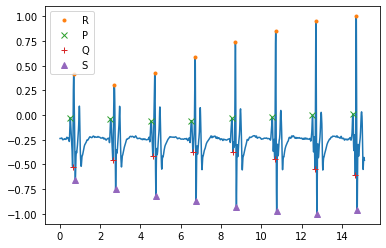

BPM -  29.92207792207793
Bradycardia


In [5]:
import matplotlib.pyplot as plt

import numpy as np

import pywt

import pywt.data


#importing module for detecting peak
from scipy.signal import find_peaks

#xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx



# Importing modules
import spidev               


# To communicate with SPI devices
from numpy import interp    # To scale values

from time import sleep      # To add delay

import RPi.GPIO as GPIO    # To use GPIO pins





# Start SPI connection

# Created an object
spi = spidev.SpiDev() 
spi.open(0,0)

GPIO.setmode(GPIO.BCM)
 
# Read MCP3204 data
def analogInput(channel):
  spi.max_speed_hz = 1350000
  adc = spi.xfer2([1,(8+channel)<<4,0])
  data = ((adc[1]&3) << 8) + adc[2]
  return data




counter = 0

#creating a file pointer
f = open("30.txt","w+")

#the  loop where the 4001 values are read
while (counter <= 4000):
    output = analogInput(0) # Reading from CH0
    #output = interp(output, [0, 1023], [0, 100])
    #print(output)
    
    #writing the data in the file 30.txt
    f.write(str(output)+'\n')
    
    sleep(0.001) #values are displayed every 1ms
    
    counter += 1


#closing the file pointer    
f.close()



# Reading data from text file
with open("30.txt", "r") as fp:
    #for storing data value
    data_set=[]
    
    for data_point in fp:
        #stripping data for removing white spaces and converting to integer
        data_set.append(int(data_point.strip()))
    
    plt.close('all')
    

    #extracting data
    x=data_set[100:3000]
    #converting array
    x = np.array(x)
    w = pywt.Wavelet('sym5')
    nl = 5
    coeffs = pywt.wavedec(x, w, level=nl)
    
    def reconstruction_plot(yyy, **kwargs):
        

        ym = np.median(yyy)
        k=yyy-ym
        l=np.linspace(0, 1., num=len(yyy))

        return k
        

    
    
    xmax = x.max()
    
    i=1
    plt.figure()

    
    filtered_data=(reconstruction_plot(pywt.waverec(coeffs[:i+2] + [None] * (nl-i-1), w)))

    plt.legend(['DWT'])
    valueInt = []
    rvalues=[]
    for x in filtered_data:
        

        valueInt.append(x)
    p=np.linspace(0, 1., num=len(pywt.waverec(coeffs[:i+2] + [None] * (nl-i-1), w))) 

    valueInt = np.array(valueInt)
    
    data_in_mv=[]
    
    for m in valueInt:
        new_m=(m/1023)*5
        data_in_mv.append(new_m)
        new_m=0
    data_in_mv=np.array(data_in_mv) 

    maximun_x=max(data_in_mv)
    minimum_x=min(data_in_mv)
    normalised_valueInt=[]
    for x in data_in_mv:
        new_x=(2*((x-minimum_x)/(maximun_x-minimum_x)))-1
        normalised_valueInt.append(new_x)
        new_x=0
    normalised_valueInt=np.array(normalised_valueInt) 
    peaks, _ = find_peaks(normalised_valueInt, prominence=0.40)
    
    r_peaks,_=find_peaks(normalised_valueInt,prominence=0.75)
    peaks_time=[]
    time_one_sample=1/192
    for p in r_peaks:
        new_p=p*(time_one_sample)
        peaks_time.append(new_p)
    
    c=0
    time_axis=[]
    no_of_samples=[]
    
    for x in range(0,len(normalised_valueInt)):
        c=c+1
        time_axis.append(c*time_one_sample)
        no_of_samples.append(c)
    
    plt.plot(time_axis,normalised_valueInt)
    r_peaks_time=[]
    for k in r_peaks:
        new_k=k*(time_one_sample)
        r_peaks_time.append(new_k)        
    plt.plot(r_peaks_time,normalised_valueInt[r_peaks],'.',label='R')
    
    
    #xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
    all_peaks=[]
    p_values=[]
    clone_used_in_p=normalised_valueInt
    peaks1, _ = find_peaks(normalised_valueInt)
    for m in peaks1:
        all_peaks.append(m)
        
    
    pvalues_test=[]
    pvalues1=[]
    st = set(r_peaks)
    index_of_r_values=[i for i, e in enumerate(all_peaks) if e in st]
    
    for k in index_of_r_values:
    
        pvalues_test.append(all_peaks[k-1])
        pvalues_test.append(all_peaks[k-2])
    
        for m in pvalues_test:
            pvalues1.append(normalised_valueInt[m])
        pmax=(max(pvalues1))
        index_of_maximum = (np.where(clone_used_in_p == pmax))
        
        for x in index_of_maximum:
            
            p_values.append(x[0])
        
        pvalues_test=[]
        pvalues1=[]
    p_time=[]
    
    
    for c in p_values:
    
        new_p= (c * (time_one_sample))
        p_time.append(new_p)
        
    plt.plot(p_time, normalised_valueInt[p_values], "x",label='P')
    
    #xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
    Q_values=[]
    c=0
    for k in index_of_r_values:
        
        left_side_peak=all_peaks[k-1]
        xtended_interval=left_side_peak-20
        sliced_data=normalised_valueInt[xtended_interval:r_peaks[c]]
        c=c+1
        Qmin=min(sliced_data)
        index_of_minimum = (np.where(clone_used_in_p == Qmin))
        for x in index_of_minimum:
            
            Q_values.append(x[0])
        
        sliced_data=[]
    Q_time=[]
    
    
    for c in Q_values:
    
        new_q= (c * (time_one_sample))
        Q_time.append(new_q)
           
    plt.plot(Q_time, normalised_valueInt[Q_values], "+",label='Q')  
    
    #xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
    
    S_values=[]
    c=0
    for k in index_of_r_values:
        
        sliced_data_s=normalised_valueInt[r_peaks[c]:r_peaks[c]+40]
        c=c+1
        Smin=min(sliced_data_s)
        index_of_minimum_s = (np.where(clone_used_in_p == Smin))
        for x in index_of_minimum_s:
            
            S_values.append(x[0])
        
        sliced_data_s=[]
    
    S_time=[]
    for c in S_values:
    
        new_s= (c * (time_one_sample))
        S_time.append(new_s)
    
    plt.plot(S_time, normalised_valueInt[S_values], "^",label='S') 
            
    
    plt.legend(loc="upper left")    
    
    plt.show()
    
    
    
    
    arr = [y-x for x, y in zip(r_peaks_time[:-1], r_peaks_time[1:])]
    bpm = 600/((sum(arr)/len(arr))*10)
    print('BPM - ', bpm)
    
    
    if bpm < 60:
        print('Bradycardia')
    elif bpm < 100:
        print('Normal')
    elif bpm < 120:
        print('Tachycardia')
        
            
    
     